In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import scipy
import pybel
import sys

from rdkit import Chem
from rdkit.Chem.Lipinski import NumAromaticRings
from rdkit.Chem import PandasTools

import matplotlib.pyplot as plt

%matplotlib inline

# Notebook with datasets generator for aromatic rings experiments

In this notebook one can prepare train and test datasets for Mol-CycleGAN experiments, for the following datasets:

1. Dataset A - molecules with 2 aromatic rings
2. Dataset B - molecules with 1 or 3 aromatic rings

## Read ZINC dataset and calculate number of aromatic rings for every molecule

In [2]:
def calculate_number_of_aromatic_rings(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return NumAromaticRings(mol)


def create_dataset_with_function(path, function, new_col_name):
    df = pd.read_csv(path)
    print("df shape: {}".format(df.shape))
    
    df.dropna(inplace=True)
    df.drop_duplicates(subset='smiles', inplace=True)
    print("df shape after dropping nans and duplicates: {}".format(df.shape))
    
    df[new_col_name] = df['smiles'].apply(function)
    
    df.dropna(inplace=True)
    print("df shape after applying function: {}".format(df.shape))
    
    df = df[['smiles', new_col_name]].set_index('smiles')
    
    print("Final df shape: {}".format(df.shape))
          
    return df

In [3]:
X_JTVAE = pd.read_csv('../X_JTVAE_250k_rndm_zinc.csv', index_col=0)

In [4]:
df = create_dataset_with_function(path='../250k_rndm_zinc_drugs_clean_3_canonized.csv', 
                                  function=calculate_number_of_aromatic_rings, 
                                  new_col_name='aromatic_rings')

print("Number of molecules in the ZINC dataset: %d" % df.shape[0])

df shape: (249455, 4)
df shape after dropping nans and duplicates: (249455, 4)
df shape after applying function: (249455, 5)
Final df shape: (249455, 1)
Number of molecules in the ZINC dataset: 249455


## Plot aromatic rings distribution in the ZINC dataset

(0, 0.5)

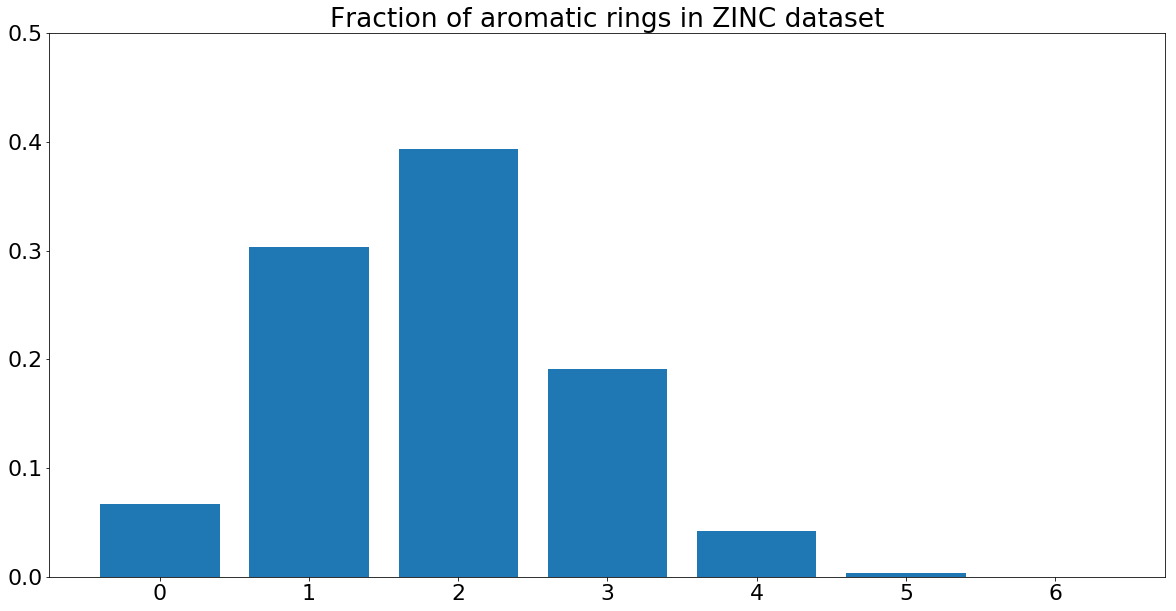

In [5]:
smiles = df['aromatic_rings'].values
ar_counts = np.bincount(smiles) / float(len(smiles))

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.title('Fraction of aromatic rings in ZINC dataset')
plt.bar(range(7), ar_counts)
plt.ylim((0, 0.5))

## Create train and test datasets
1. set A = molecules with 2 aromatic rings
2. set B = molecules with 1 or 3 aromatic rings

In [6]:
# Take only mols with 1,2,3 aromatic rings
mols_to_stay = np.logical_or.reduce((df['aromatic_rings'].values == 1, df['aromatic_rings'].values == 2, df['aromatic_rings'].values == 3))
df_experiment = df.iloc[mols_to_stay]
print("Number of molecules with 1/2/3 aromatic rings: %d" % df_experiment.shape[0])

Number of molecules with 1/2/3 aromatic rings: 221413


In [7]:
# Split molecules into dataset A and B
A_indices = df_experiment['aromatic_rings'].values == 2

df_A = df_experiment.iloc[A_indices]
df_B = df_experiment.iloc[~A_indices]

print("Number of molecules in dataset A: %d" % df_A.shape[0])
print("Number of molecules in dataset B: %d" % df_B.shape[0])

Number of molecules in dataset A: 98220
Number of molecules in dataset B: 123193


In [8]:
# Sanity check of datasets
assert set(df_A['aromatic_rings'].values) == set([2])
assert set(df_B['aromatic_rings'].values) == set([1,3])

In [9]:
# Split datasets into train and test datasets.
train_size = 80000

# split set A to train/test
train_sample_A = np.zeros(df_A.shape[0], dtype=bool)
train_sample_A[np.random.choice(df_A.shape[0], train_size, replace=False)] = True

df_train_A = df_A.iloc[train_sample_A]
df_test_A = df_A.iloc[~train_sample_A]
print("Number of molecules in dataset train_A: %d" % df_train_A.shape[0])
print("Number of molecules in dataset test_A: %d" % df_test_A.shape[0])

# split set B to train/test
train_sample_B = np.zeros(df_B.shape[0], dtype=bool)
train_sample_B[np.random.choice(df_B.shape[0], train_size, replace=False)] = True

df_train_B = df_B.iloc[train_sample_B]
df_test_B = df_B.iloc[~train_sample_B]
print("Number of molecules in dataset train_B: %d" % df_train_B.shape[0])
print("Number of molecules in dataset test_B: %d" % df_test_B.shape[0])

Number of molecules in dataset train_A: 80000
Number of molecules in dataset test_A: 18220
Number of molecules in dataset train_B: 80000
Number of molecules in dataset test_B: 43193


## Plot aromatic rings distribution in train and test datasets

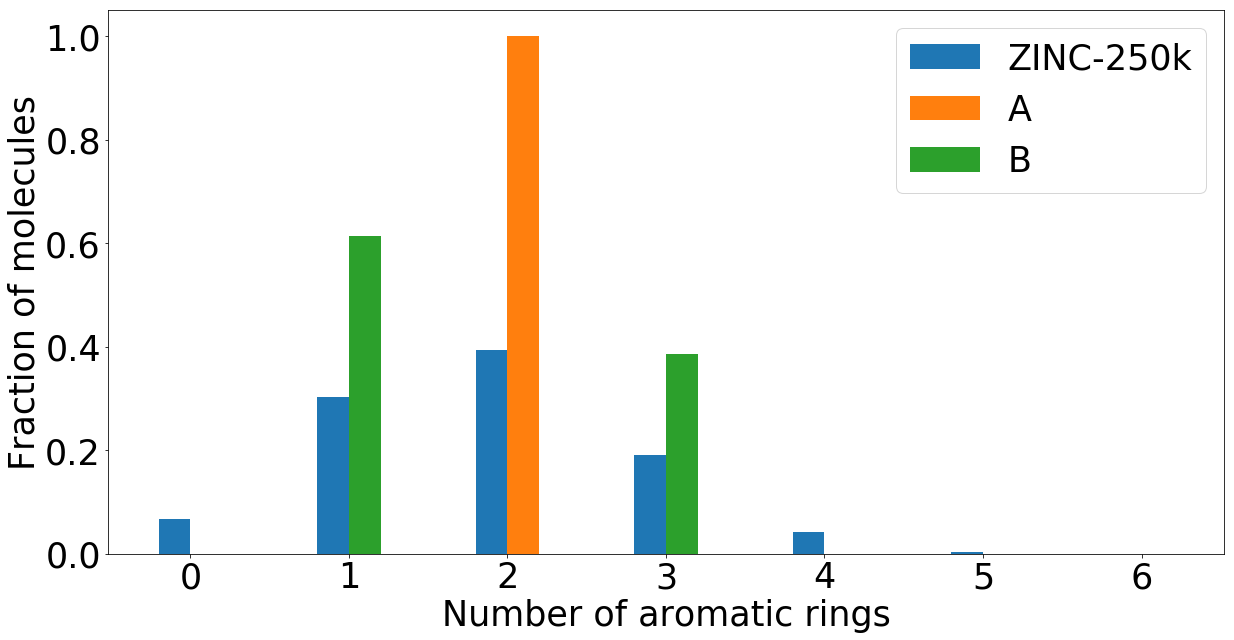

In [10]:
df_counts = np.bincount(df['aromatic_rings'].values) / float(len(df['aromatic_rings'].values))
df_A_counts = np.bincount(df_A['aromatic_rings'].values) / float(len(df_A['aromatic_rings'].values))
df_B_counts = np.bincount(df_B['aromatic_rings'].values) / float(len(df_B['aromatic_rings'].values))

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 35})

ax = plt.subplot(111)
ax.bar(np.arange(7)-0.1, df_counts, width=0.2, label='ZINC-250k')
ax.bar(np.arange(7)+0.1, np.concatenate([df_A_counts, np.repeat(0., 4)]), width=0.2, label='A')
ax.bar(np.arange(7)+0.1, np.concatenate([df_B_counts, np.repeat(0., 3)]), width=0.2, label='B')

plt.ylim((0, 1.05))

plt.ylabel('Fraction of molecules')
plt.xlabel('Number of aromatic rings')

plt.legend()

## Save datasets

In [11]:
X_JTVAE_zinc_train_A = X_JTVAE.loc[df_train_A.index]
X_JTVAE_zinc_test_A = X_JTVAE.loc[df_test_A.index]

X_JTVAE_zinc_train_B = X_JTVAE.loc[df_train_B.index]
X_JTVAE_zinc_test_B = X_JTVAE.loc[df_test_B.index]

print(X_JTVAE_zinc_train_A.shape, X_JTVAE_zinc_test_A.shape, 
      X_JTVAE_zinc_train_B.shape, X_JTVAE_zinc_test_B.shape)

((80000, 56), (18220, 56), (80000, 56), (43193, 56))


In [12]:
X_JTVAE_zinc_train_A.to_csv('X_JTVAE_zinc_train_A.csv')
X_JTVAE_zinc_test_A.to_csv('X_JTVAE_zinc_test_A.csv')
X_JTVAE_zinc_train_B.to_csv('X_JTVAE_zinc_train_B.csv')
X_JTVAE_zinc_test_B.to_csv('X_JTVAE_zinc_test_B.csv')